In [1]:
from tdc.single_pred import ADME
from tqdm import tqdm
from tdc.benchmark_group import admet_group
import numpy as np
from tdc.single_pred import Tox

data = ADME(name = 'Caco2_Wang')
split = data.get_split()
train,test = split['train'],split['test']

Found local copy...
Loading...
Done!


In [2]:
from warnings import filterwarnings
import numpy as np
from rdkit import Chem
from mordred import Calculator, descriptors 
calc = Calculator(descriptors, ignore_3D=True)
from wash import dataset_wash
from wash import NeutraliseCharges

def smile_to_modred(smile):
    return calc(Chem.MolFromSmiles(smile))

def get_modred(smiles):
    paws = []
    for smile in smiles:
        paws.append(np.asarray(smile_to_modred(smile)))
    return paws

train['Drug'] = train['Drug'].apply(NeutraliseCharges)
test['Drug'] = test['Drug'].apply(NeutraliseCharges)

trains = [Chem.MolFromSmiles(s) for s in train["Drug"]]
trDes = calc.pandas(trains)

## Convert strings to NaN
trDes = trDes.apply(pd.to_numeric,errors='coerce')
trDes.fillna(0,inplace=True)


trDes.replace([np.inf, -np.inf], np.nan, inplace=True)    
print(trDes.shape)

tests = [Chem.MolFromSmiles(s) for s in test["Drug"]]
teDes = calc.pandas(tests)

teDes = teDes.apply(pd.to_numeric,errors='coerce')
teDes.fillna(0,inplace=True)


teDes.replace([np.inf, -np.inf], np.nan, inplace=True)    
print(teDes.shape)


 14%|██████████▉                                                                      | 86/637 [00:03<00:26, 20.50it/s]

C:\Users\Abhik\anaconda3\envs\rdkit\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 43%|██████████████████████████████████▍                                             | 274/637 [00:08<00:09, 36.45it/s]

C:\Users\Abhik\anaconda3\envs\rdkit\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Abhik\anaconda3\envs\rdkit\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Abhik\anaconda3\envs\rdkit\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\Abhik\anaconda3\envs\rdkit\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 54%|███████████████████████████████████████████▌                                    | 347/637 [00:10<00:06, 43.11it/s]

C:\Users\Abhik\anaconda3\envs\rdkit\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 91%|████████████████████████████████████████████████████████████████████████▍       | 577/637 [00:18<00:01, 34.87it/s]

C:\Users\Abhik\anaconda3\envs\rdkit\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:19<00:00, 32.59it/s]


(637, 1613)


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:05<00:00, 31.78it/s]


C:\Users\Abhik\anaconda3\envs\rdkit\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
(182, 1613)


In [3]:
tr_df = pd.DataFrame(trDes)
tr_df = tr_df.loc[:, tr_df.var() > 0.0] ## remove constant columns

tr_df.replace([np.inf, -np.inf], np.nan, inplace=True)
trdf = np.array(tr_df,dtype=float)


## Keep same number of columns for test and train for prediction
te_df = pd.DataFrame(teDes)
te_df = te_df[tr_df.columns]
tedf = np.array(te_df,dtype=float)

tr_y = np.array(train.Y)
te_y = np.array(test.Y)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn import preprocessing
from modAL.models import ActiveLearner, CommitteeRegressor
from modAL.disagreement import max_std_sampling
#from joblib import Parallel, delayed
from copy import deepcopy
import math
import time
from datetime import datetime

def committee_active_learner_qsar(X_train, Y_output, test,ty, i):
    
  print(datetime.now())
  rmse_pool = []
  mae_pool = [] 
  r2_pool = []
  r2_test = []
  
  X_pool = deepcopy(X_train)
  y_pool = deepcopy(Y_output)
  
  X_train_std = deepcopy(X_train)
  y_train_std = deepcopy(Y_output)
  
  RANDOM_STATE_SEED = i
  np.random.seed(RANDOM_STATE_SEED)
  
  # initializing the regressors
  n_initial = 100
  

  initial_idx = list()
  initial_idx.append(np.random.choice(range(200), size=n_initial, replace=False))
  initial_idx.append(np.random.choice(range(200, X_train.shape[0]), size=n_initial, replace=False))

  learner_list=[]
  X_training=[]
  y_training=[]
  count=0
  for idx in initial_idx:
    
    if count==0:
      X_training = X_train_std[idx]
      y_training = y_train_std[idx]
    
    else:
      X_training = np.append(X_training, X_train_std[idx], axis=0)
      y_training = np.append(y_training, y_train_std[idx])
     
    learner_list.append(ActiveLearner(
                        estimator = ExtraTreesRegressor(n_estimators=250, random_state=0),
                        X_training=X_train_std[idx], y_training=y_train_std[idx]
                        ))
    count = count+1
    
  X_pool = np.delete(X_pool, initial_idx, axis=0)
  y_pool = np.delete(y_pool, initial_idx)
  
  ### initializing the Committee ###
  committee = CommitteeRegressor(
              learner_list=learner_list,
              query_strategy=max_std_sampling
              )

  #### active regression ####
  n_queries = 50
  batch_size = 1
  iteration = []
  for idx in range(n_queries):
        query_idx, query_instance = committee.query(X_pool)
          
        X_batch = X_pool[query_idx]
        y_batch = y_pool[query_idx]     
          
        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx)        
        
        r2_pool.append(r2_score(y_pool, committee.predict(X_pool)))  
        rmse_pool.append(math.sqrt(mean_squared_error(y_pool, committee.predict(X_pool))))
        mae_pool.append(mean_absolute_error(y_pool, committee.predict(X_pool))  )      
        committee.teach(X_batch, y_batch)
        iteration.append(idx+1)
        r2_test.append(r2_score(np.array(ty), committee.predict(test))) 
        
       
  return mae_pool, r2_pool,r2_test,initial_idx, iteration

2023-01-02 22:04:18.312750
2023-01-02 22:10:28.972826
2023-01-02 22:16:32.244274
2023-01-02 22:22:39.788418
2023-01-02 22:28:46.923450


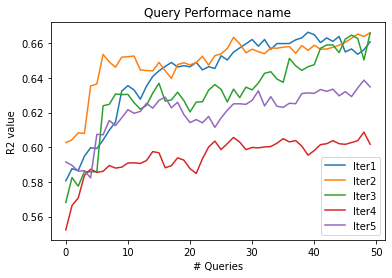

In [5]:
## Using 5 iterations to check model R2 
number_of_iterations = 5

#results = Parallel(n_jobs=2)(delayed(committee_active_learner)(X_train, Y_output, i) for i in range(number_of_iterations))

res = []
for i in range(number_of_iterations):
    
    results = committee_active_learner_qsar(trdf, tr_y,tedf,te_y, i) 
    res.append(results)
    
    
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [11, 7]
x1 = range(50)
y1 = res[0][2]
y2 = res[1][2]
y3 = res[2][2]
y4 = res[3][2]
y5 = res[4][2]
plt.plot(x1, y1,label ='Iter1')
plt.plot(x1, y2,label ='Iter2')
plt.plot(x1, y3,label ='Iter3')
plt.plot(x1, y4,label ='Iter4')
plt.plot(x1, y5,label ='Iter5')

plt.title('Query Performace name')
plt.xlabel('# Queries')
plt.ylabel('R2 value')
plt.legend()
plt.show()    